Importing the appropriate libraries

In [238]:
import numpy as np 
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import time
import datetime,re
import pprint
import seaborn as sns
import wordcloud
import itertools

import re
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import pyLDAvis.sklearn
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob

# Examining Media Sentiment Regarding BLM Protests 

Given the recent surge in Black Lives Matter protests, I aim to examine media coverage of the events and see if there are any differences in reporting among conservative, liberal, and neutral news outlets. Using AllSides' Bias Rating System, to represent the categories I chose Fox News, New York Times, and USA Today respectively. 

#### Hypothesis: 

Given the history of these political biases, I predict Fox News will be critical, USA Today will be neutral, and New York Times will be favorable in coverage towards these protests. 

# Exploratory Questions:

1. How did sentiment change over time? Were there significant differences between news sources? 
2. How similar are the contents of each corpus?
3. What were the topics after LDA topic modeling? 
4. Are the results consistent with the hypothesis?

# Scraping newspaper articles to create the corpus

### Using the NYTimes API to get Query URLs

Below function generates query URLs to get articles from

In [2]:
#function to generate query URLs
def genQueryURL(date, query):
    base_url = 'http://api.nytimes.com/svc/search/v2/articlesearch.json?'
    query = 'q=' + query #has to be of form topic+search+...
    
    facet_fields = 'facet_fields=source'
    facet = 'facet=true'
    
    beg_date = 'begin_date=' + str(date) #yyyymmdd
    end_date = 'end_date=' + str(date)
    
    sort = 'sort=newest'
    key = 'api-key=apAAplTXZ8kLinM6huT5n2NsmNxHe8hw'

    full = base_url + query +  "&" + facet_fields + "&" + facet + "&" + beg_date + "&" + end_date + "&" + sort + "&" + key
    return full 

Compiling the URLs into a dictionary with the dates as keys and values as lists of URLs from that day

In [6]:
#querying dates from 5/25/20 to 6/18/20
dates = np.concatenate((np.arange(20200525, 20200532), np.arange(20200601,20200621))) 
#dates = np.arange(20200525, 20200529)
query = "black+lives+matter+protests"
query_url_dict = {}
for date in dates:
    query_url_dict[date] = genQueryURL(date, query)

Checking that dictionary was created successfully:

In [7]:
len(query_url_dict)

27

In [8]:
query_url_dict.keys()

dict_keys([20200525, 20200526, 20200527, 20200528, 20200529, 20200530, 20200531, 20200601, 20200602, 20200603, 20200604, 20200605, 20200606, 20200607, 20200608, 20200609, 20200610, 20200611, 20200612, 20200613, 20200614, 20200615, 20200616, 20200617, 20200618, 20200619, 20200620])

In [9]:
query_urls = query_url_dict.values()
for url in query_urls:
    print(url)

http://api.nytimes.com/svc/search/v2/articlesearch.json?q=black+lives+matter+protests&facet_fields=source&facet=true&begin_date=20200525&end_date=20200525&sort=newest&api-key=apAAplTXZ8kLinM6huT5n2NsmNxHe8hw
http://api.nytimes.com/svc/search/v2/articlesearch.json?q=black+lives+matter+protests&facet_fields=source&facet=true&begin_date=20200526&end_date=20200526&sort=newest&api-key=apAAplTXZ8kLinM6huT5n2NsmNxHe8hw
http://api.nytimes.com/svc/search/v2/articlesearch.json?q=black+lives+matter+protests&facet_fields=source&facet=true&begin_date=20200527&end_date=20200527&sort=newest&api-key=apAAplTXZ8kLinM6huT5n2NsmNxHe8hw
http://api.nytimes.com/svc/search/v2/articlesearch.json?q=black+lives+matter+protests&facet_fields=source&facet=true&begin_date=20200528&end_date=20200528&sort=newest&api-key=apAAplTXZ8kLinM6huT5n2NsmNxHe8hw
http://api.nytimes.com/svc/search/v2/articlesearch.json?q=black+lives+matter+protests&facet_fields=source&facet=true&begin_date=20200529&end_date=20200529&sort=newest&a

### Creating a database from Query URLs

To store the data, I used a dataframe with article title, url, author, pub date, and text as columns. 
Below code is a function creating the rows for the dataframe. 

In [10]:
#reformate date so it's easier to read
def format_date(original):
    d = str(original)
    return d[4:6]  + "-" + d[6:] + "-" + d[:4]

In [11]:
#req = requests.get(q).json() for some query_url_dict
def generate_row(req, article_num, date):
    docs = req["response"]["docs"][article_num]
    title = docs["headline"]['main']
    art_type = docs['section_name']
    url = docs["web_url"]

    #this code below from https://towardsdatascience.com/easily-scrape-and-summarize-news-articles-using-python-dfc7667d9e74
    r= requests.get(url).text
    soup = BeautifulSoup(r)
    ptags = soup.find_all("p")
    p_tags_text = [tag.get_text().strip() for tag in ptags]
    # Filter out sentences that contain newline characters '\n' or don't contain periods.
    sentence_list = [sentence for sentence in p_tags_text if not '\n' in sentence]
    sentence_list = [sentence for sentence in sentence_list if '.' in sentence]
    # Combine list items into string.
    text = ' '.join(sentence_list)
    
    return [title, format_date(date), art_type, url, text]

In [12]:
#adds the rows for each query url 
def each_query(url, date, data):
    req = requests.get(url).json()
    time.sleep(2)
    num_articles = len(req["response"]["docs"])
    for i in range(num_articles):
        row = generate_row(req, i, date)
        data.loc[data.shape[0]] = row

In [13]:
def create_df(query_dict):
    data1 = pd.DataFrame(columns = ["Title", "Date of Publication", "Type of Article",  "URL", "Text"])
    for date in query_dict.keys():
        each_query(query_dict[date], date, data1)
        print("done adding for date", format_date(date)) 
    return data1

Can't run the below code too many times too frequently or else it will error out. This code complies the articles scraped from NYTimes into a single dataframe

In [14]:
#timing how long it runs:
start = time.time()
nytimes = create_df(query_url_dict)
end = time.time()
print("It took ", end - start, " seconds to run")

done adding for date 05-25-2020
done adding for date 05-26-2020
done adding for date 05-27-2020
done adding for date 05-28-2020
done adding for date 05-29-2020
done adding for date 05-30-2020
done adding for date 05-31-2020
done adding for date 06-01-2020
done adding for date 06-02-2020
done adding for date 06-03-2020
done adding for date 06-04-2020
done adding for date 06-05-2020
done adding for date 06-06-2020
done adding for date 06-07-2020
done adding for date 06-08-2020
done adding for date 06-09-2020
done adding for date 06-10-2020
done adding for date 06-11-2020
done adding for date 06-12-2020
done adding for date 06-13-2020
done adding for date 06-14-2020
done adding for date 06-15-2020
done adding for date 06-16-2020
done adding for date 06-17-2020
done adding for date 06-18-2020
done adding for date 06-19-2020
done adding for date 06-20-2020
It took  206.1713891029358  seconds to run


In [15]:
nytimes.head()

,Title,Date of Publication,Type of Article,URL,Text
0,"Joe Biden, Wearing Mask, Appears in Public at ...",05-25-2020,U.S.,https://www.nytimes.com/2020/05/25/us/politics...,The presumptive Democratic nominee made a publ...
1,12 Restaurants America Loves. With Recipes!,05-26-2020,Food,https://www.nytimes.com/interactive/2020/05/26...,We’re making food from our favorite restaurant...
2,‘I Can’t Breathe’: 4 Minneapolis Officers Fire...,05-26-2020,U.S.,https://www.nytimes.com/2020/05/26/us/minneapo...,“Being black in America should not be a death ...
3,Long Island Is on the Verge of Reopening,05-26-2020,New York,https://www.nytimes.com/2020/05/26/nyregion/co...,A restart would leave New York City as the onl...
4,Emergency Child Hunger Program Is Far Behind o...,05-26-2020,U.S.,https://www.nytimes.com/2020/05/26/us/coronavi...,About a dozen states are seeing an uptick in c...


Here we can see we got 246 articles from NYTimes 

In [17]:
nytimes.shape

(246, 5)

Saving this pandas table because it takes a while to run and it's good to have a backup.

In [19]:
nytimes.to_pickle("./NytimesData")

### USA Today News Data Scraping 

This is a little different because there is no API I could find. So here, I'll start off with collecting all the URLs that the query returns and directly scrape off the website.

In [20]:
def query_url_generator(q, page):
    return 'https://www.usatoday.com/search/?' + 'q=' + q + '&page=' + str(page) 

In [21]:
links = []
q = 'black+lives+matter+protests'
page = 1

while True: 
    query_url = query_url_generator(q, page)
    article = requests.get(query_url)
    time.sleep(0.25)
    if article.status_code == 404: 
        print("all " + str(page - 1) + " pages have already been scraped!")
        break
    
    page += 1
    usa_soup = BeautifulSoup(article.content, "html.parser")
    mess = usa_soup.find_all('a', class_="gnt_se_a gnt_se_a__hd gnt_se_a__hi")

    for i in range(len(mess)):
        full_url = 'https://www.usatoday.com/' + mess[i]["href"]
        links.append(full_url)
        

all 5 pages have already been scraped!


Here you can see the links I've collected for the query requests

In [22]:
links

['https://www.usatoday.com//story/news/nation/2020/06/25/pride-month-2020-queer-kentuckians-lead-black-lives-matter-movement/3256095001/',
 'https://www.usatoday.com//story/entertainment/music/2020/06/24/stevie-wonder-calls-action-black-lives-matter-movement/3248577001/',
 'https://www.usatoday.com//story/entertainment/celebrities/2020/06/22/black-lives-matter-supermodel-joan-smalls-pledges-half-2020-wages/3239400001/',
 'https://www.usatoday.com//story/news/investigations/2020/06/19/so-far-george-floyd-protests-not-behind-surges-coronavirus/3226033001/',
 'https://www.usatoday.com//story/news/nation/2020/06/17/black-lives-matter-painted-city-streets-see-art-nyc-washington/3204742001/',
 'https://www.usatoday.com//story/news/nation/2020/06/17/bethel-ohio-protests-black-lives-matter-meets-small-town-america/3207842001/',
 'https://www.usatoday.com//story/news/nation/2020/06/17/fbi-arrests-texas-man-black-lives-matter-death-threats-youtube/3211978001/',
 'https://www.usatoday.com//story/

Since I'm only interested in articles and some of these link to videos among other media formats, we're now going to filter out ones that don't start with "https://www.usatoday.com//story/"

In [23]:
just_stories = []
for link in links:
    if link[:32] == 'https://www.usatoday.com//story/':
        just_stories.append(link)

Now we're left with 89 articles (as of 6/20/20). EDIT: As of 6/26/20, two articles were deleted

In [25]:
len(just_stories)

87

Now its time to create a dataframe storing all the data for USA Today

In [26]:
#timing how long this takes:
start = time.time()

usatoday = pd.DataFrame(columns = ["Title", "Date of Publication", "Type of Article",  "URL", "Text"])
links_completed = 0
for link in just_stories: 
    page  = requests.get(link).text
    soup = BeautifulSoup(page)
    title = soup.find('h1').get_text()
    
    noslash = link[32:].replace("/", "")
    date = re.search('2020(\d+)', noslash).group()
    
    trunc_link = link[32:]
    art_type = re.search('^([^/])+', trunc_link).group()
   
    # code block below from https://towardsdatascience.com/easily-scrape-and-summarize-news-articles-using-python-dfc7667d9e74
    p_tags = soup.find_all('p')
    # Get the text from each of the “p” tags and strip surrounding whitespace.
    p_tags_text = [tag.get_text().strip() for tag in p_tags]
    # Filter out sentences that contain newline characters '\n' or don't contain periods.
    sentence_list = [sentence for sentence in p_tags_text if not '\n' in sentence]
    sentence_list = [sentence for sentence in sentence_list if '.' in sentence]
    # Combine list items into string.
    text = ' '.join(sentence_list)
    
    row = [title, format_date(date), art_type, link, text]
    usatoday.loc[usatoday.shape[0]] = row
    
    links_completed += 1
    time.sleep(1)
    print(links_completed, " links added to dataframe!")

end = time.time()
print("It took ", end - start, " seconds to run the code")

1  links added to dataframe!
2  links added to dataframe!
3  links added to dataframe!
4  links added to dataframe!
5  links added to dataframe!
6  links added to dataframe!
7  links added to dataframe!
8  links added to dataframe!
9  links added to dataframe!
10  links added to dataframe!
11  links added to dataframe!
12  links added to dataframe!
13  links added to dataframe!
14  links added to dataframe!
15  links added to dataframe!
16  links added to dataframe!
17  links added to dataframe!
18  links added to dataframe!
19  links added to dataframe!
20  links added to dataframe!
21  links added to dataframe!
22  links added to dataframe!
23  links added to dataframe!
24  links added to dataframe!
25  links added to dataframe!
26  links added to dataframe!
27  links added to dataframe!
28  links added to dataframe!
29  links added to dataframe!
30  links added to dataframe!
31  links added to dataframe!
32  links added to dataframe!
33  links added to dataframe!
34  links added to 

In [27]:
usatoday.head()

,Title,Date of Publication,Type of Article,URL,Text
0,Black queer pride: LGBTQ Kentuckians at the fo...,06-25-2020,news,https://www.usatoday.com//story/news/nation/20...,2020's Pride Month looks different. June has b...
1,Stevie Wonder calls for action on Black Lives ...,06-24-2020,entertainment,https://www.usatoday.com//story/entertainment/...,"Wonder said he has listened to ""voices on the ..."
2,Supermodel Joan Smalls pledges wages to Black ...,06-22-2020,entertainment,https://www.usatoday.com//story/entertainment/...,Joan Smalls pledges half of her 2020 wages to ...
3,Coronavirus surges aren't linked to Black Live...,06-19-2020,news,https://www.usatoday.com//story/news/investiga...,Protests were as common in places with surging...
4,Powerful photos show 'Black Lives Matter' pain...,06-17-2020,news,https://www.usatoday.com//story/news/nation/20...,"""Black Lives Matter"" has been painted on stree..."


Saving this dataframe as well:

In [29]:
usatoday.to_pickle("./UsaTodayData")

# Now time to do the same for the Fox News

It was at this point I discovered the NewsAPI which does a lot of this process under the hood, but limits the results to 100 articles. The following code cell generates a json of all the results for the search term 'black lives matter protests' between the dates of May 25,2020 and June 18, 2020 from Fox News. EDIT: when I ran through the code again, NewsAPI no longer allowed me to access the date of May 25th, 2020. But when I manually checked what articles were published for this specific query on that day, there were none, so this technically didn't do anything

In [32]:
#code based off of: https://www.geeksforgeeks.org/newspaper-scraping-using-python-and-news-api/
key = "f3c116e002964739803d79fa5ab9f864" 
   
# Define the endpoint 
url = 'https://newsapi.org/v2/everything?'
   
# Specify the query and 
# number of returns 
parameters = { 
    'q': 'black+lives+matter+protests', # query phrase 
    'pageSize': 100,  # maximum is 100 
    'apiKey': key, # your own API key 
    'sources': "fox-news",
    'from' : '2020-05-26',
    'to' : '2020-06-20'
} 
   
# Make the request 
response = requests.get(url,  
                        params = parameters) 
   
# Convert the response to  
# JSON format and pretty print it 
response_json = response.json() 
pprint.pprint(response_json) 

{'articles': [{'author': 'Louis Casiano',
               'content': 'New York City police officers were seen clashing '
                          'with demonstrators in\xa0another night of mass '
                          'gatherings Thursday in a city that has seen some of '
                          'the worst violence since George Floyd protests '
                          'began m… [+4445 chars]',
               'description': '<ol><li>NYPD confronts George Floyd '
                              'demonstrators as curfew takes effect\xa0\xa0Fox '
                              'News\r\n'
                              '</li><li>Video of deliveryman arrest draws '
                              'rebuke from NYC mayor\xa0\xa0New York Daily '
                              'News\r\n'
                              '</li><li>NYPD confronts George Floyd crowds as '
                              'curfew takes effect; Buffalo clash gets 2…',
               'publishedAt': '2020-06-05T01:34:05Z',


               'description': 'Socialists are trying to hijack the movement to '
                              'advance black causes\xa0so that they can usher '
                              'in a radical, far-left revolution.',
               'publishedAt': '2020-06-11T16:26:00Z',
               'source': {'id': 'fox-news', 'name': 'Fox News'},
               'title': 'Justin Haskins: George Floyd riots — socialists, '
                        'radicals hijacking peaceful protests to do this',
               'url': 'https://www.foxnews.com/opinion/george-floyd-riots-socialists-radicals-hijacking-peaceful-protests-justin-haskins',
               'urlToImage': 'https://static.foxnews.com/foxnews.com/content/uploads/2020/06/seattle-protest-4-Getty-Images.jpg'},
              {'author': 'Joseph Wulfsohn',
               'content': 'Actor Evan Peters was criticized on social media '
                          'for sharing a tweet that referred to "piece of s--- '
                          'l

               'source': {'id': 'fox-news', 'name': 'Fox News'},
               'title': 'Protest organizers say South LA deliberately avoided '
                        'to target more affluent areas instead',
               'url': 'https://www.foxnews.com/us/protest-organizers-south-la-deliberately-avoided-target-affluent-areas',
               'urlToImage': 'https://static.foxnews.com/foxnews.com/content/uploads/2020/06/AP20155142371549.jpg'},
              {'author': 'Lucia Suarez Sang',
               'content': 'Hundreds of Australians marched in solidarity '
                          'through downtown Sydney on Tuesday protesting the '
                          'death of George Floyd and demanding the country '
                          'look at police brutality within its borders.\r\n'
                          'More than… [+4150 chars]',
               'description': 'Hundreds of Australians marched in solidarity '
                              'through downtown Sydney on Tuesd

Now it's time to define a function that takes in this json and builds a dataframe for this site like we've been doing with the previous news sites

In [33]:
#inspired by https://towardsdatascience.com/scraping-web-articles-using-newsapi-in-python-a0e97fbab8ed

#Slightly different from the format_date function which takes in a string of the form 'yyyymmdd' 
#this one takes the string format given by the newsapi search ex. 2020-06-05T01:34:05Z	
def fix_date(og_dates): 
    fixed = []
    for date in og_dates:
        fix = date[5:10] + '-' + date[:4]
        fixed.append(fix)
    return fixed

#returns all the information in dictionary form we can extract using the NewsAPI - we are still missing the article type and full text for the final data frame
#the content key for the response json only returns a partial text
def getAPI_info(file):
    title = []
    url = []
    date = []
    for i in range(len(file)):
        title.append(file[i]['title'])
        url.append(file[i]['url']) 
        date.append(file[i]['publishedAt'])
    fixed_format_dates = fix_date(date)
    return {'Title':title, 'Date of Publication':fixed_format_dates, 'URL':url}

#takes in a list of URLs and returns a list with the corresponding texts; the texts are gotten in the same way as NYTimes 
def getFoxText(urls):
    texts = []
    for url in urls:
        r= requests.get(url).text
        time.sleep(1)
        soup = BeautifulSoup(r)
        ptags = soup.find_all("p")
        p_tags_text = [tag.get_text().strip() for tag in ptags]
     
        sentence_list = [sentence for sentence in p_tags_text if not '\n' in sentence]
        sentence_list = [sentence for sentence in sentence_list if '.' in sentence]
   
        text = ' '.join(sentence_list)
        texts.append(text)
    return texts 

#takes list of URLs and extracts article type from them and returns list of corresponding article types
#done in same way as I did it for USA Today 
def getFoxArtType(urls):
    urls = []
    for i in range(len(articles)):
        trunc = articles[i]['url'][24:]
        art_type = re.search('^([^/])+', trunc).group()
        urls.append(art_type)
    return urls

#puts all the helper functions to build the full dataframe
def FoxDF(responses):
    newsapi = getAPI_info(responses)
    urls = newsapi['URL']
    texts = getFoxText(urls)
    art_type = getFoxArtType(urls)
    final_dic = {"Title":newsapi["Title"], 
                 "Date of Publication":newsapi["Date of Publication"], 
                'Type of Article':art_type, 
                'URL':urls,
                'Text':texts}
    return pd.DataFrame(data=final_dic)

Putting together all the functions I've defined and making a dataframe for Fox News. 

In [34]:
start = time.time()
articles = response_json['articles']
foxNews = FoxDF(articles)
end = time.time()
print('It took ', end - start, ' seconds to generate the database')
foxNews.head()

It took  195.60640454292297  seconds to generate the database


,Title,Date of Publication,Type of Article,URL,Text
0,NYPD confronts George Floyd demonstrators as c...,06-05-2020,us,https://www.foxnews.com/us/nypd-confronts-geor...,Former Ohio State football captain and sneaker...
1,Kendall Jenner responds to accusations she pho...,06-09-2020,entertainment,https://www.foxnews.com/entertainment/kendall-...,Fox News Flash top entertainment and celebrity...
2,Lawmaker blasts Amazon’s ‘performative’ suppor...,06-17-2020,tech,https://www.foxnews.com/tech/lawmaker-amazon-p...,Fox News Flash top headlines are here. Check o...
3,Joe Concha calls out hypocrisy of mainstream m...,06-16-2020,media,https://www.foxnews.com/media/joe-concha-calls...,The Hill media reporter Joe Concha on the medi...
4,Evangelical leaders support Black Lives Matter,06-02-2020,us,https://www.foxnews.com/us/evangelicals-suppor...,"Dr. Alveda King, niece of Dr. Martin Luther Ki..."


Saving the dataframe

In [35]:
foxNews.to_pickle("./FoxNewsData")

## Phew~ Finally done with scraping data. Let's clean the data!
Note: all the content in the 'Text' column was generated as if 'black lives matter protests' were being searched on the news websites.

In [127]:
def clean_df(df):
     #remove the rows where the articles are opinions - those are not counted because the target research is just the regular articles
    #though it would be an interesting research to see the degree to which opinion articles are in agreement with the other articles
    df = df[(df["Type of Article"] != 'opinion') & (df["Type of Article"]!= 'Opinion')].copy()
    
    #first 3 lines of code from Prof. Muzzall's DIGHUM101 Practice course, 5-1 Topic Modelling Notebook 
    # Remove punctuation
    df["Processed"] = df["Text"].map(lambda x: re.sub('[,\.!?]', '', x))

    # Convert to lowercase
    df["Processed"] = df["Processed"].map(lambda x: x.lower())

    # Remove digits
    df['Processed'] = df['Processed'].str.replace('\d+', '')
    
     #remove non important phrases
    phrases = ['a link has been posted to your facebook feed',
         '©  usa today a division of gannett satellite information network llc',
        "thank you for supporting our journalism you can\xa0subscribe to our print edition ad-free app ",
        "or electronic newspaper replica here our fact check work is supported in part by a grant from facebook",
         "a link has been sent to your friend's email address. ",
         'this material may not be published, broadcast, rewritten, or redistributed.',
         '©2020 fox news network, llc. all rights reserved. ',
         'all market data delayed 20 minutes.',
         'fox news flash top entertainment and celebrity headlines are here. ',
         "check out what's clicking today in entertainment.",
         "fox news flash top headlines are here. check out what's clicking on foxnews.com.",
        "fox news flash top entertainment and celebrity headlines are here check out what\'s clicking today in entertainment ",
        "this material may not be published broadcast rewritten or redistributed © fox news network llc all rights reserved all market data delayed  minutes",
              "fox news flash top headlines are here check out what\'s clicking on foxnewscom amazon ",
              "fox news flash top headlines are here check out what's clicking on",
              "foxnewscom new york",
              "foxnewscom",
              "contributed to this report ",
            ]
    #removes the above unrelated phrases 
    def strip(phrases_list, t): 
        for i in phrases_list:
            t = t.replace(i, '')
        return t
    
    df['Processed'] = df['Processed'].map(lambda x: strip(phrases, x))
    
    # Remove stop words
    def remove_stop(string):
        stop = set(stopwords.words('english'))
        token = string.split()
        no_stop_tokenized = [word for word in token if word not in stop]
        return no_stop_tokenized
    
    df['No Stopwords, Tokenized'] = df['Processed'].map(lambda x: remove_stop(x))
    return df

There! Code all cleaned. 

In [135]:
nyt = clean_df(nytimes)
usa = clean_df(usatoday)
fox = clean_df(foxNews)

In [646]:
print(nyt.shape)
nyt.head(3)

(214, 7)


,Title,Date of Publication,Type of Article,URL,Text,Processed,"No Stopwords, Tokenized"
0,"Joe Biden, Wearing Mask, Appears in Public at ...",05-25-2020,U.S.,https://www.nytimes.com/2020/05/25/us/politics...,The presumptive Democratic nominee made a publ...,the presumptive democratic nominee made a publ...,"[impossible, land, leave, ceremonies, golfing,..."
1,12 Restaurants America Loves. With Recipes!,05-26-2020,Food,https://www.nytimes.com/interactive/2020/05/26...,We’re making food from our favorite restaurant...,we’re making food from our favorite restaurant...,"[renovation, hugs, lobster, highways, literall..."
2,‘I Can’t Breathe’: 4 Minneapolis Officers Fire...,05-26-2020,U.S.,https://www.nytimes.com/2020/05/26/us/minneapo...,“Being black in America should not be a death ...,“being black in america should not be a death ...,"[“they, discharging, large, lawyer, pandemic, ..."


In [647]:
print(usa.shape)
usa.head(3)

(84, 7)


,Title,Date of Publication,Type of Article,URL,Text,Processed,"No Stopwords, Tokenized"
0,Black queer pride: LGBTQ Kentuckians at the fo...,06-25-2020,news,https://www.usatoday.com//story/news/nation/20...,2020's Pride Month looks different. June has b...,'s pride month looks different june has been f...,"['s, pride, month, looks, different, june, fil..."
1,Stevie Wonder calls for action on Black Lives ...,06-24-2020,entertainment,https://www.usatoday.com//story/entertainment/...,"Wonder said he has listened to ""voices on the ...","wonder said he has listened to ""voices on the ...","[wonder, said, listened, ""voices, left, voices..."
2,Supermodel Joan Smalls pledges wages to Black ...,06-22-2020,entertainment,https://www.usatoday.com//story/entertainment/...,Joan Smalls pledges half of her 2020 wages to ...,joan smalls pledges half of her wages to blac...,"[joan, smalls, pledges, half, wages, black, li..."


In [648]:
print(fox.shape)
fox.head(3)

(99, 7)


,Title,Date of Publication,Type of Article,URL,Text,Processed,"No Stopwords, Tokenized"
0,NYPD confronts George Floyd demonstrators as c...,06-05-2020,us,https://www.foxnews.com/us/nypd-confronts-geor...,Former Ohio State football captain and sneaker...,former ohio state football captain and sneaker...,"[former, ohio, state, football, captain, sneak..."
1,Kendall Jenner responds to accusations she pho...,06-09-2020,entertainment,https://www.foxnews.com/entertainment/kendall-...,Fox News Flash top entertainment and celebrity...,kendall jenner has responded to accusations sh...,"[kendall, jenner, responded, accusations, phot..."
2,Lawmaker blasts Amazon’s ‘performative’ suppor...,06-17-2020,tech,https://www.foxnews.com/tech/lawmaker-amazon-p...,Fox News Flash top headlines are here. Check o...,which last week imposed a one-year ban on sell...,"[last, week, imposed, one-year, ban, selling, ..."


Also going to save these because they take a while to make 

In [149]:
nyt.to_pickle("./nyt")
usa.to_pickle("./usa")
fox.to_pickle("./fox")

# Time for some simple exploratory data analysis

Pretty_graphs is a function that prints out a bar graph counting how many types of each article there are, along with a line graph showing the amount of articles published per day for the time period collected. 

In [367]:
def pretty_graphs(df, newsource):
    plt.figure()
    counts = df['Type of Article'].value_counts().values
    labels = df['Type of Article'].value_counts().index
    plot = sns.barplot(x=labels, y=counts)
    plt.xlabel('Type of Article')
    plt.ylabel('Count')
    plt.title('Article Type Breakdown' + " " + '(' + newsource + ')')
    plt.xticks(rotation=90);
 
    plt.figure()
    counts = df['Date of Publication'].value_counts().values
    labels = df['Date of Publication'].value_counts().index

    #the date labels ended up looking clunky so I've formatted them to exlude the year of publication
    f = labels.format()
    short = []
    for d in labels.format():
        short.append(d[:5])

    plot = sns.lineplot(x=short, y=counts)
    plt.xlabel('Date of Publication')
    plt.ylabel('Count')
    plt.title('Dates Published in 2020' + " " + '(' + newsource + ')')
    plt.xticks(rotation=65);

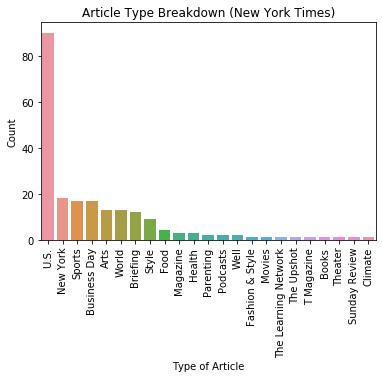

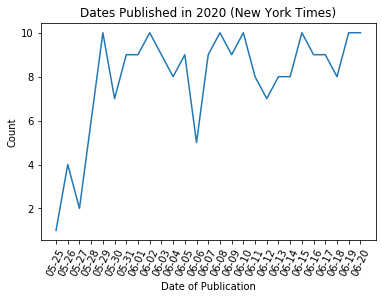

In [368]:
pretty_graphs(nyt, "New York Times") 

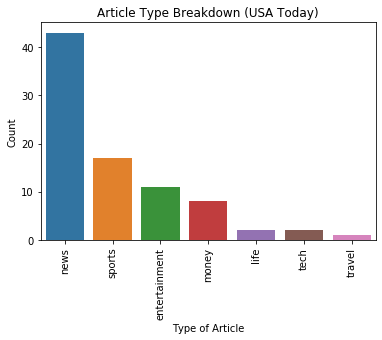

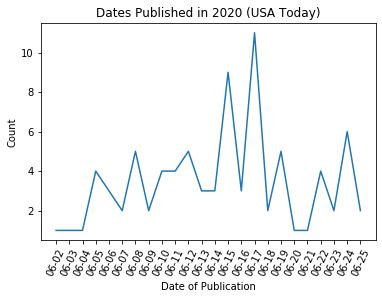

In [369]:
pretty_graphs(usa, "USA Today") 

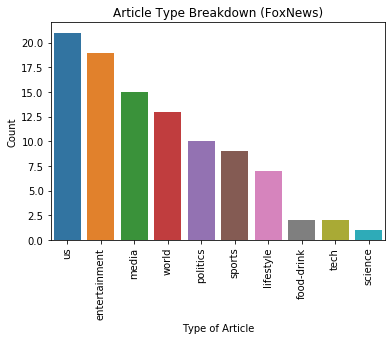

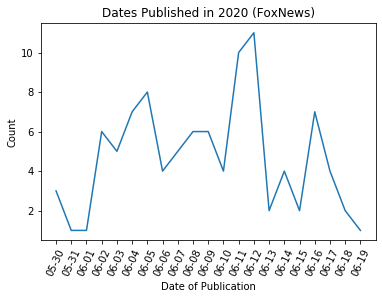

In [370]:
pretty_graphs(fox, "FoxNews")

# How big is the corpus? 

Let's calculate the number of words for each organization

In [371]:
def size_calc(df, newsource):
    info = df["Text"].tolist()
    one_str = ' '.join(info)
    print("This corpus from " + newsource + " has around " + str(len(one_str)) + ' words.')
    return len(one_str)

In [372]:
nyt_count = size_calc(nyt, "New York Times")
usa_count = size_calc(usa, "USA Today")
fox_count = size_calc(fox, "FoxNews")
print("For a total of", nyt_count + usa_count + fox_count, "words")

This corpus from New York Times has around 1868083 words.
This corpus from USA Today has around 485152 words.
This corpus from FoxNews has around 287064 words.
For a total of 2640299 words


# What are some of the most common words for each News Source?

In [631]:
#cleaning nyt some more because a symbol wasn't taken out properly 
def remove_slash(tokens_list):
    tokens = set(tokens_list)
    return [word for word in tokens if word != '—'] 

nyt['No Stopwords, Tokenized'] = nyt['No Stopwords, Tokenized'].map(lambda x:remove_slash(x))

Most_common is a function that returns the specified amount of most frequent words. 

In [632]:
def most_common(num,df):
    nst = df["No Stopwords, Tokenized"].tolist() #this is list of lists, want just list of strings 
    flatten = list(itertools.chain(*nst))
    counted = Counter(flatten)
    return pd.DataFrame(counted.most_common(num), columns = ['Word', 'Counts'])

Computing the most common words and putting the information into a dataframe:

In [641]:
info = []
dfs = [fox, usa, nyt]
for df in dfs: 
    counts = most_common(10,df) 
    words = np.array(counts['Word'].tolist())
    freq = np.array(counts['Counts'].tolist())
    info.append(words)
    info.append(np.around(freq/sum(freq), 3))
info = np.concatenate(np.array(info)).reshape(6,10)

#making the dataframe
index = pd.MultiIndex.from_product([['FoxNews', 'USA Today', 'New York Times'], 
                                    ['Word', 'Counts']], names = ['Newspaper', 'Results'])
col = np.arange(1,11)
most_common_words = pd.DataFrame(info, index, col)
most_common_words

1       2       3       4       5         6   \
Newspaper      Results                                                    
FoxNews        Word     black  police   lives  matter    said  protests   
               Counts    0.16    0.15    0.13   0.098   0.096     0.091   
USA Today      Word     black    said  police   lives  people    matter   
               Counts   0.206   0.163   0.134   0.104   0.094     0.076   
New York Times Word     black    said  police  people     one      also   
               Counts   0.116   0.111   0.106   0.104   0.101     0.096   

                              7       8       9           10  
Newspaper      Results                                        
FoxNews        Word        floyd  people  george       death  
               Counts      0.079   0.068   0.065       0.063  
USA Today      Word     protests     one   white  protesters  
               Counts      0.072   0.053   0.053       0.044  
New York Times Word       george    many     new       would  
               Counts      0.093   0.092   0.092       0.088

# Generating Word Clouds

In [396]:
def wc_gen(text, color, name):
    #change the value in return to set the single color need, in hsl format.
    def color_func(word, font_size, position,orientation,random_state=None, **kwargs):
        return("hsl(" + color +"%%, %d%%)" % np.random.randint(49,51))

    #create the word cloud object, only want max 100 words
    wc = wordcloud.WordCloud(background_color='white',max_font_size = 40, max_words = 100).generate(text)

    #change the color setting
    wc.recolor(color_func = color_func)
    plt.figure(figsize=(10,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig(name +".jpeg", dpi = 300)
    plt.show();

Word cloud for Fox News 

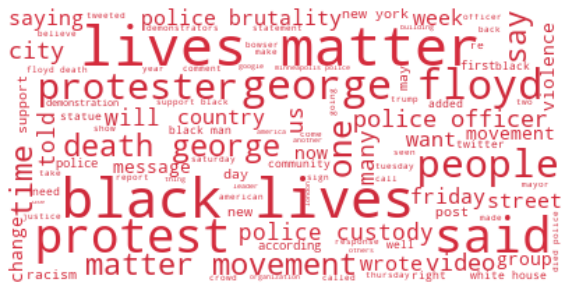

In [643]:
wc_gen(" ".join(fox["Processed"].tolist()), '354,66', 'fox wc')

Word cloud for USA Today:

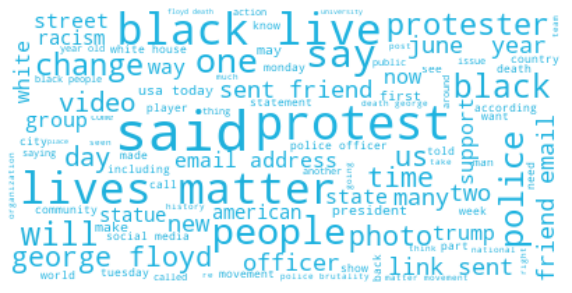

In [644]:
wc_gen(" ".join(usa["Processed"].tolist()), '194,76', 'usa wc')

Word cloud for NY Times

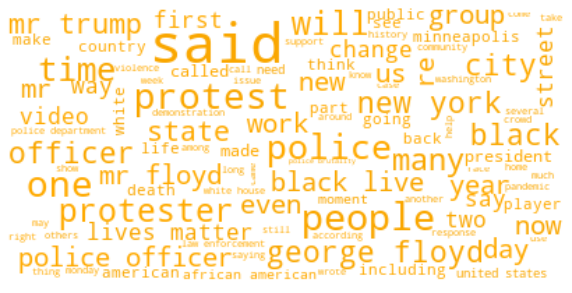

In [645]:
wc_gen(" ".join(nyt["Processed"].tolist()), '40,100', 'nyt wc')

# Topic Modeling: Latent Dirichlet Allocation

Flatten_everything contains the tokens of every text from every newspaper. Need this as input for the TfidfVectorizer

In [381]:
flatten_everything = list(itertools.chain(*nyt['No Stopwords, Tokenized'].tolist())) \
                                    +  list(itertools.chain(*usa['No Stopwords, Tokenized'].tolist())) \
                                    +  list(itertools.chain(*fox['No Stopwords, Tokenized'].tolist()))

In [382]:
# TfidfVectorizer to create the DTM
tfidf_vectorizer = TfidfVectorizer(max_df = 0.90, max_features = 5000, stop_words = "english")
tfidf = tfidf_vectorizer.fit_transform(flatten_everything)

# Instantiate our LDA model
lda = LatentDirichletAllocation(n_components = 3, max_iter = 20, random_state = 3)
lda = lda.fit(tfidf)

The following print_top_words function along with the pyLDAvis cell was code taken from Professor Evan Muzzall's DIGHUM 101: Practicing the Digital Humanities course. Specifically, it comes from his Week 5-1 Topic Modeling Notebook which can be found at this URL: https://github.com/dlab-berkeley/DIGHUM101-2020/blob/master/Notebooks/Week5/5-1_topic-modeling.ipynb

In [383]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
print()

In [384]:
entire_text_one_string = " ".join(nyt["Processed"].tolist()) + " ".join(usa["Processed"].tolist()) + " ".join(fox['Processed'].tolist())
tf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(lda, tf_feature_names, 20)


Topic #0:
black people new matter protesters officers death protest york justice say state video law years change right times states violence

Topic #1:
said police protests white like president time ms minneapolis officer racism week national social going don media know told use

Topic #2:
mr floyd lives city trump george man country coronavirus department movement american day year house public community support including want


In [385]:
panel = pyLDAvis.sklearn.prepare(lda_model = lda, 
                                 dtm = tfidf, 
                                 vectorizer = tfidf_vectorizer, 
                                 mds = "tsne")
pyLDAvis.display(panel)

C:\Users\Sarah\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


# Sentiment Analysis

Two sentiment analysis libraries were used: vaderSentiment and Texblob. Each has their own strengths. vaderSentiment says if the document is positive, negative, or neutral, and TextBlob gives a subjectivity and objectivity score.

From the vaderSentiment documentation regarding translating the continuous value of compound score into a discrete distribution: 

"It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

positive sentiment: compound score >= 0.05
neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
negative sentiment: compound score <= -0.05"

URL: https://github.com/cjhutto/vaderSentiment#code-examples

### vaderSentiment

The following function computes and adds the negative, neutral, positive, and compound scores to the dataframe. Taking the compound score, it then categorizes as positive, negative, or neutral according to the definition above. 

In [671]:
#sorting defined in line with the vaderSentiment documentation
def sorting(val):
    if val < 0.05 and val > -0.05:
        return 'neutral'
    elif val >= 0.05:
        return 'positive'
    return 'negative'
#adds the vaderSentiment values
def add_vaderSentiment(df):
    analyzer = SentimentIntensityAnalyzer()
    sentences = df.copy()["Text"].tolist()
    neg = []
    neu = []
    pos = []
    compound = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        neg.append(vs['neg'])
        neu.append(vs['neu'])
        pos.append(vs['pos'])
        compound.append(vs['compound'])
    df['vS neg'] = neg
    df['vS neu'] = neu
    df['vS pos'] = pos
    df['vS compound'] = compound
    df['vS Overall Sentiment'] = df['vS compound'].map(lambda x: sorting(x))

### TextBlob

From the TextBlob documentation:

"The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective."

URL: https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis

The following function adds these two scores to the dataframe

In [239]:
def add_TextBlob(df):
    sub_pol_pairs = df["Text"].map(lambda x: TextBlob(x).sentiment)
    polarity = []
    subjectivity = []
    for i in sub_pol_pairs:
        polarity.append(i.polarity)
        subjectivity.append(i.subjectivity)
    df["tB polarity"] = polarity
    df['tB subjectivity'] = subjectivity

In [413]:
#We don't need these columns anymore
def drop_cols(df):
    df.drop(columns = ['Title', 'URL', 'Text', 'Processed', 'No Stopwords, Tokenized'], inplace = True)


Since these functions change the original dataframes, lets make a copy to have a backup just in case something goes wrong.

In [658]:
n = nyt.copy()
u = usa.copy()
f = fox.copy()

Making the new dataframes by adding vaderSentimenet and TextBlob scores.

In [659]:
start = time.time()
dfs = [n,u,f]
for df in dfs:
    add_vaderSentiment(df)
    add_TextBlob(df)
    drop_cols(df)
end = time.time()
print("This took ", end - start, "seconds to run")

This took  141.9924192428589 seconds to run


### How many of each sentiment type does each News organization have?  

In [686]:
def vsp(df, name):
    counts = df.groupby('vS Overall Sentiment').count()[['vS compound']]
    counts['vS compound'] = np.around(counts['vS compound'] / df.shape[0], 2)
    counts.rename(columns={"vS compound":name + ' Counts'}, inplace = True)
    return counts

In [700]:
df1 = vsp(f, 'Fox News')
df2 = vsp(u, 'USA Today ')
df3 = vsp(n, 'New York Times ')

df4 = df3.merge(df2, how = 'left', left_index = True, right_index = True)
df5= df4.merge(df1, how = 'left', left_index = True, right_index = True)
df5.fillna(0, inplace = True)
df5

,New York Times Counts,USA Today Counts,Fox News Counts
vS Overall Sentiment,,,
negative,0.68,0.69,0.66
neutral,0.01,0.00,0.00
positive,0.31,0.31,0.34


### Do these groupings remain the same when I use TextBlob's polarity scoring?
 
 Let's examine Textblob's polarity score which should be similar to vaderSentiment's compound score. For consistency, the sorting algorithm will be same, which is fine since both scores have an interval of [-1,1]

In [703]:
def tbp(df, name):
    c = df.copy()
    c = c[['tB polarity']]
    c['tB Overall Sentiment'] = c['tB polarity'].map(lambda x: sorting(x))
    counts = c.groupby('tB Overall Sentiment').count()[['tB polarity']]
    counts['tB polarity'] = np.around(counts['tB polarity'] / df.shape[0], 2)
    counts.rename(columns={'tB polarity': name + ' Counts'}, inplace = True)
    return counts

In [704]:
df1 = tbp(f, 'Fox News')
df2 = tbp(u, 'USA Today ')
df3 = tbp(n, 'New York Times ')

df4 = df3.merge(df2, how = 'left', left_index = True, right_index = True)
df5= df4.merge(df1, how = 'left', left_index = True, right_index = True)
df5.fillna(0, inplace = True)
df5

,New York Times Counts,USA Today Counts,Fox News Counts
tB Overall Sentiment,,,
negative,0.04,0.04,0.07
neutral,0.48,0.57,0.51
positive,0.48,0.39,0.42


It seems like vaderSentiment and TextBlob have very different interpretations of the text's polarity. 

### Which types of articles are most subjective? 

In [664]:
def group(df):
    grouped  = df.groupby('Type of Article').agg({'tB subjectivity': 'mean', 'vS Overall Sentiment': 'count'})
    grouped.rename(columns = {'vS Overall Sentiment':'Counts'}, inplace = True)
    return grouped[grouped['Counts'] > 5].sort_values('tB subjectivity', ascending = False)

Fox News

In [665]:
group(f)

,tB subjectivity,Counts
Type of Article,,
sports,0.423976,9
entertainment,0.423459,19
lifestyle,0.421896,7
media,0.418317,15
politics,0.387927,10
us,0.363122,21
world,0.356666,13


USA Today 

In [666]:
group(u)

,tB subjectivity,Counts
Type of Article,,
entertainment,0.450633,11
sports,0.406783,17
money,0.390942,8
news,0.375305,43


New York Times

In [667]:
group(n)

,tB subjectivity,Counts
Type of Article,,
Briefing,0.435967,12
Style,0.429718,9
New York,0.410229,18
Sports,0.407823,17
U.S.,0.391221,90
Arts,0.387684,13
Business Day,0.377064,17
World,0.354786,13


# Graphing + Analyzing the Numerical results:

Scatter_graph plots 4 graphs: 

1. vaderSentiment's negative, neutral, and positive proportions 
2. vaderSentiment's compound sentiment score 
3. Textblob's polarity 
4. Texblob's subjectivity

In [653]:
def scatter_graph(df, name):
    colors = ['#ffb41f', '#d94554', '#30a9cf']
    colors2 = ['#864ba3','#dc99ff', '#380f4d']
    #plotting vaderSentiment's negative, neutral, and positive proportions 
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (15,15))
    fig.suptitle(name + ' Sentiment over Time')
    x = [date[:5] for date in df['Date of Publication'].tolist()]
    ys = [df['vS neu'].tolist(), df['vS neg'].tolist(), df['vS pos'].tolist()]
    labels = ['neutral', 'negative', 'positive']
    for i in range(len(ys)):
        ax1.scatter(x, ys[i], label = labels[i], color = colors2[i]);
    ax1.legend()
    ax1.set_ylabel('vaderSentiment Proportion of Text in the Category')
    ax1.set_xlabel('Date of Publication')
    ax1.set_title('Proportion of Each Sentiment Category Over Time') 
    
    #plotting the compound sentiment score 
    y= df['vS compound'].tolist()
    ax2.scatter(x,  y, label = 'compound score', color = colors[0]);
    ax2.set_ylabel('vaderSentiment Compound Score')
    ax2.set_xlabel('Date of Publication')
    ax2.set_title('Compound Score Over Time \u03BC=' + str(np.mean(y))[:5] + ' \u03C3=' + str(np.std(y))[:5])
    
    #plotting Textblob's polarity 
    y = df['tB polarity'].tolist()
    ax3.plot(x, np.zeros(len(y)), '#42f57e') #adding y = 0 line to more easily tell how these scores fall
    ax3.scatter(x,y, color = colors[1]);
    ax3.set_ylabel('TextBlob Polarity Score')
    ax3.set_xlabel('Date of Publication')
    ax3.set_title('Polarity Score Over Time \u03BC=' + str(np.mean(y))[:5] + ' \u03C3=' + str(np.std(y))[:5])
    
    #plotting Texblob's subjectivity
    y = df['tB subjectivity'].tolist()
    ax4.scatter(x, y, color = colors[2]);
    ax4.set_ylabel('TextBlob Subjectivity Score')
    ax4.set_xlabel('Date of Publication')
    ax4.set_title('Subjectivity Score Over Time \u03BC=' + str(np.mean(y))[:5] + ' \u03C3=' + str(np.std(y))[:5])
    
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=90)
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=90)
    plt.setp(ax4.xaxis.get_majorticklabels(), rotation=90)
    plt.savefig(name + '.jpg')


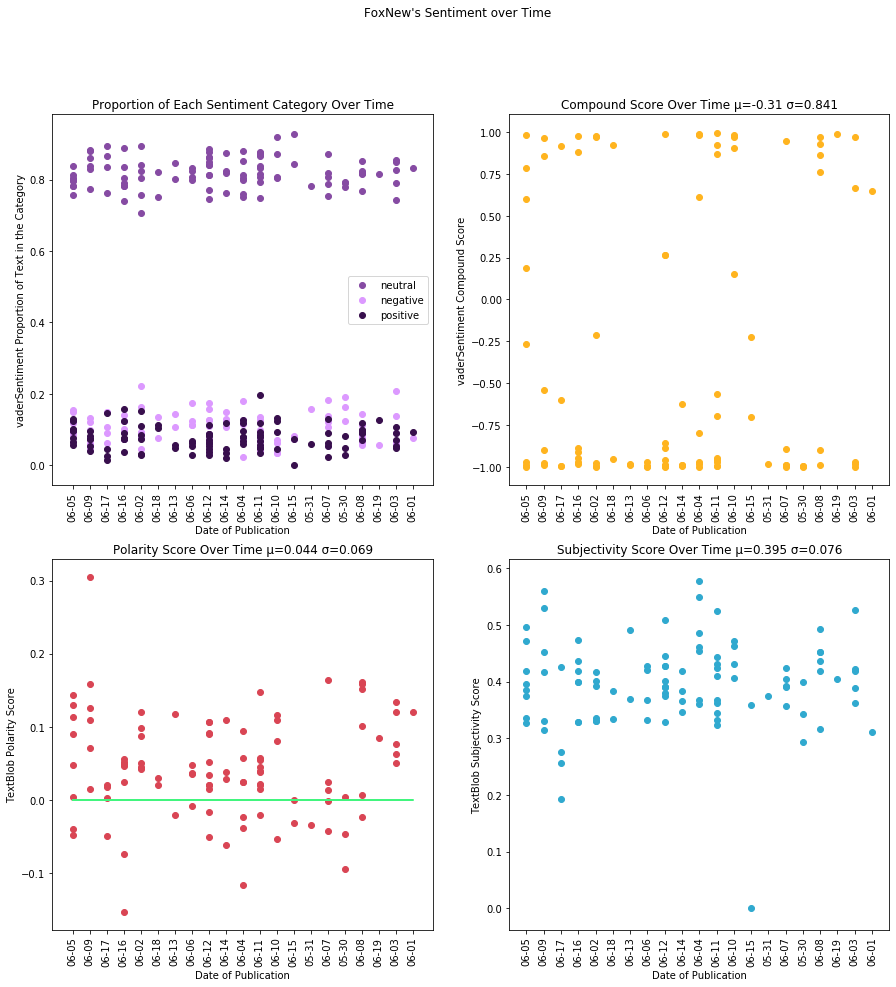

In [654]:
scatter_graph(f, "FoxNew's")

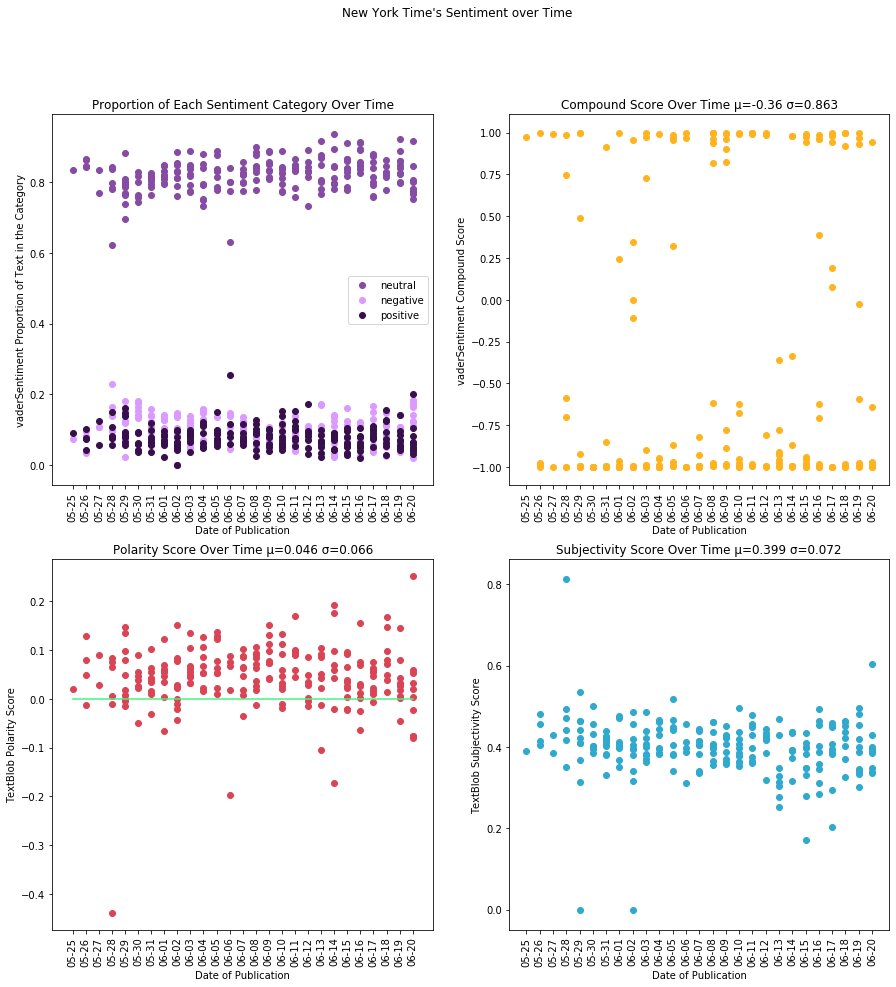

In [660]:
scatter_graph(n, "New York Time's")

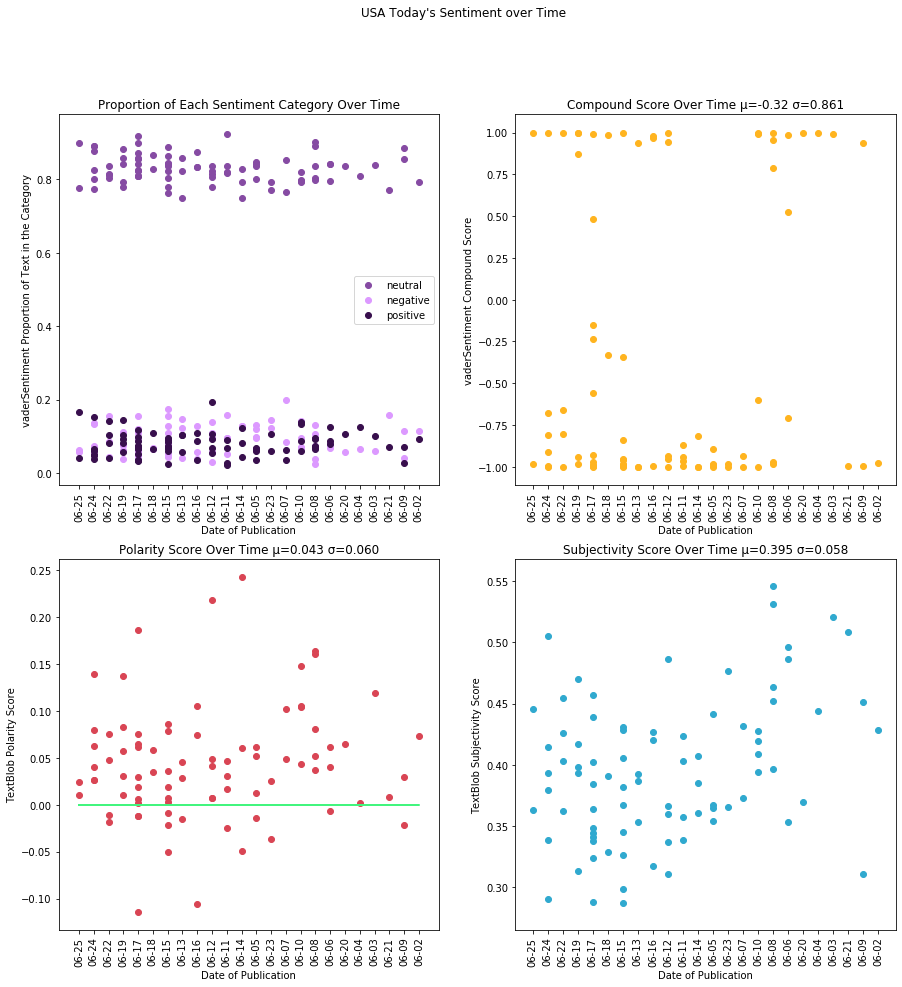

In [656]:
scatter_graph(u, "USA Today's")

# Conclusion

The evidence from the word clouds and sentiment analysis definetly suggest there are differences in how the newspapers covered the Black Lives Matter protests. But I can't really say in good faith anything concrete about my initial hypothesis, that Fox News would be critical of these protests, USA Today would be neutral, and the New York Times would be favorable.This is because the initial methodology is too limited. 

While I did measure positive/negative sentiment and examine the contents of the articles from a higher level perspective in the form of word clouds and LDA, I did not take into account what content was being rated as negative or positive. For example, if the articles were negatively connotated, was it because they were criticizing the police or because they were criticizing the protester? Both examples lead to negative tags and increased importance on the words “protester” and “police” but one is generally associated with being supportive of the protesters (criticizing police) while the other is the opposite. Therefore, further research would work on resolving these issues. 


### Presented by Sarah Jiang on July 5th 2020, for Professor Adam Anderson's DIGHUM 100: Theory & Methods class. 

# Works Cited (Code)

Boularouk, SaÏd. “Newspaper Scraping Using Python and News API.” *GeeksforGeeks,* 26 Feb. 2020, www.geeksforgeeks.org/newspaper-scraping-using-python-and-news-api/.

Gluck, Chaim. “Easily Scrape and Summarize News Articles Using Python.” *Towards Data Science,* Medium, 21 Feb. 2020, towardsdatascience.com/easily-scrape-and-summarize-news-articles-using-python-dfc7667d9e74.

Hutto, C.J. & Gilbert, E.E. (2014). *VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text.* Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014.

Lee, Nathan. “Scraping Web Articles Using NewsAPI in Python.”*Towards Data Science,* Medium, 19 Nov. 2019, towardsdatascience.com/scraping-web-articles-using-newsapi-in-python-a0e97fbab8ed.

Loria, S. ‘Sentiment Analysis.’ *TextBlob,* https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis

Muzzall, Evan. '5-1_topic-modeling.'  *GitHub,* 21 Jun. 2020 https://github.com/dlab-berkeley/DIGHUM101-2020/blob/master/Notebooks/Week5/5-1_topic-modeling.ipynb 